# Methodology

1. **Create block splits:** This code performs a spatial analysis to determine how much of each Census block polygon falls within each TAZ (Traffic Analysis Zone), while filtering out tiny overlaps (slivers) and computing normalized area proportions.
2. Get Census Block Total Population and 18+ Population
4. Get ACS Block Group Percent of 18+ Population that is 65+
5. Calculate

4) 17 and under population for portion of block in each TAZ is based proportionally to the total population in each split block
5) 65+ population for each split block is based on the Block Group %65+ from the 2020 ACS
6) Population by Age Group from "UDOT_BlockSplit" is summed by TAZ to determine overall TAZ age pct file in tab "SumBlock"
7) Data in "SumBlock" pivot table is copied to Export and appended with MedDist information from USTM TAZs.  This is exported to a tab in _TAZ_AgePct_Lookup_Source - 2022-04-05.xlsb
8) "CheckControl" tab scales 2020 estimates by County and compares to 2019 Population by Age Controls from "_ControlTotal_SE - Source - 2022-03-01.xlsx"


In [1]:
# Import libraries
import geopandas as gpd
import pandas as pd
from census import Census
from us import states
import cenpy
import requests
import matplotlib

In [2]:
census_year = 2020
acs_year = 2020
state_fips = 49 #Utah

BASE_URL_CENSUS = 'https://api.census.gov/data/2020/dec/pl'

In [3]:
# read in taz and census block group geometries
blk_gdf = gpd.read_file("data/census/tl_2020_49_tabblock20/tl_2020_49_tabblock20.shp")
taz_gdf = gpd.read_file("data/USTMv4_20250729/USTMv4_20250729.shp")  # Must include CO_TAZID

In [4]:
# Read the Census API key from a text file
with open('ignore/census-key.txt', 'r') as f:
    CENSUS_API_KEY = f.read().strip()

from census import Census
c = Census(CENSUS_API_KEY)

In [5]:
# check if API working

from us import states

# Get total population (B01003_001E) for Utah (FIPS 49)
response = c.acs5.state(
    fields=('NAME', 'B01003_001E'),
    state_fips=states.UT.fips,
    year=acs_year
)

print(response)

[{'NAME': 'Utah', 'B01003_001E': 3151239.0, 'state': '49'}]


In [6]:
utah_counties = [
    {"name": "Beaver"     , "fips": "001"},
    {"name": "Box Elder"  , "fips": "003"},
    {"name": "Cache"      , "fips": "005"},
    {"name": "Carbon"     , "fips": "007"},
    {"name": "Daggett"    , "fips": "009"},
    {"name": "Davis"      , "fips": "011"},
    {"name": "Duchesne"   , "fips": "013"},
    {"name": "Emery"      , "fips": "015"},
    {"name": "Garfield"   , "fips": "017"},
    {"name": "Grand"      , "fips": "019"},
    {"name": "Iron"       , "fips": "021"},
    {"name": "Juab"       , "fips": "023"},
    {"name": "Kane"       , "fips": "025"},
    {"name": "Millard"    , "fips": "027"},
    {"name": "Morgan"     , "fips": "029"},
    {"name": "Piute"      , "fips": "031"},
    {"name": "Rich"       , "fips": "033"},
    {"name": "Salt Lake"  , "fips": "035"},
    {"name": "San Juan"   , "fips": "037"},
    {"name": "Sanpete"    , "fips": "039"},
    {"name": "Sevier"     , "fips": "041"},
    {"name": "Summit"     , "fips": "043"},
    {"name": "Tooele"     , "fips": "045"},
    {"name": "Uintah"     , "fips": "047"},
    {"name": "Utah"       , "fips": "049"},
    {"name": "Wasatch"    , "fips": "051"},
    {"name": "Washington" , "fips": "053"},
    {"name": "Wayne"      , "fips": "055"},
    {"name": "Weber"      , "fips": "057"},
]
county_fips_list = [c["fips"] for c in utah_counties]
utah_counties_df = pd.DataFrame(utah_counties)
utah_counties_df.columns = ['CO_NAME', 'CO_FIPS']
utah_counties_df['CO_FIPS'] = utah_counties_df['CO_FIPS'].astype(int)
utah_counties_df = utah_counties_df[['CO_FIPS', 'CO_NAME']]
utah_counties_df.to_csv('results/counties.csv', index=False)

# 1. Create Block and Tract Splits

<Axes: >

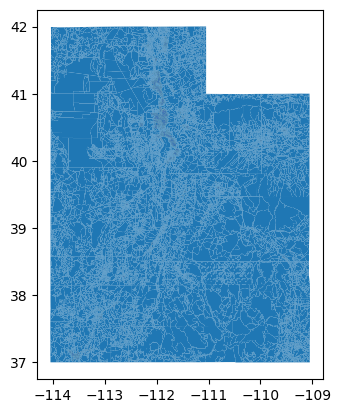

In [7]:
blk_gdf.plot()

<Axes: >

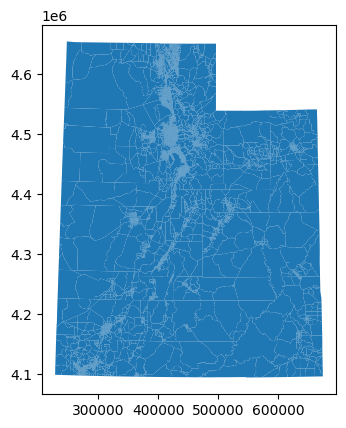

In [8]:
taz_gdf.plot()

In [9]:
import geopandas as gpd

# Match CRS
blk_crs_gdf = blk_gdf.to_crs(taz_gdf.crs).copy()

# Calculate original block area
blk_crs_gdf['blk_area'] = blk_crs_gdf.geometry.area

# Spatial intersection
intersect_gdf = gpd.overlay(blk_crs_gdf, taz_gdf[['CO_TAZID','SUBAREAID','geometry']], how='intersection')

# Calculate area of intersected pieces
intersect_gdf['intersect_area'] = intersect_gdf.geometry.area

# Merge original block area into intersected GeoDF
intersect_gdf = intersect_gdf.merge(
    blk_crs_gdf[['GEOID20', 'blk_area']], on='GEOID20'
)

# Filter out pieces <1% of original block
intersect_gdf = intersect_gdf[
    (intersect_gdf['intersect_area'] / intersect_gdf['blk_area_x']) >= 0.01
]

# Recalculate total area *remaining* per block (after filtering)
total_remaining_area = intersect_gdf.groupby('GEOID20')['intersect_area'].sum().reset_index()
total_remaining_area.rename(columns={'intersect_area': 'filtered_total_area'}, inplace=True)

# Merge back in
intersect_gdf = intersect_gdf.merge(total_remaining_area, on='GEOID20')

# Compute final ratio relative to total *remaining* block area
intersect_gdf['blk_area_ratio'] = intersect_gdf['intersect_area'] / intersect_gdf['filtered_total_area']

intersect_gdf['state' ] = intersect_gdf['GEOID20'].str.slice( 0,  2)
intersect_gdf['county'] = intersect_gdf['GEOID20'].str.slice( 2,  5)
intersect_gdf['tract' ] = intersect_gdf['GEOID20'].str.slice( 5, 11)
intersect_gdf['blk'   ] = intersect_gdf['GEOID20'].str.slice(11, 15)
intersect_gdf['blkgrp'] = intersect_gdf['GEOID20'].str.slice(11, 12)

# Final result (customize columns as needed)
block_splits_gdf = intersect_gdf[['state','county','tract','blk','blkgrp','CO_TAZID', 'blk_area_ratio', 'geometry']]
block_splits_gdf

,state,county,tract,blk,blkgrp,CO_TAZID,blk_area_ratio,geometry
0,49,047,940201,4135,4,47014.0,1.000000,"POLYGON ((599822.242 4468441.466, 599919.782 4..."
1,49,047,940201,4116,4,47014.0,1.000000,"POLYGON ((600447.484 4470941.559, 600451.73 44..."
2,49,047,940201,4038,4,47032.0,1.000000,"POLYGON ((593128.81 4486189.277, 593134.757 44..."
3,49,047,968201,2013,2,47096.0,1.000000,"POLYGON ((628910.942 4476057.924, 628900.443 4..."
4,49,035,113909,1031,1,350823.0,1.000000,"POLYGON ((409695.614 4495227.619, 409696.644 4..."
...,...,...,...,...,...,...,...,...
85957,49,005,000201,2047,2,50804.0,0.010603,"POLYGON ((429019.827 4629550.413, 429019.483 4..."
85958,49,005,000502,1020,1,50286.0,1.000000,"POLYGON ((430232.04 4623834.949, 430218.669 46..."
85959,49,043,964304,3004,3,43293.0,1.000000,"POLYGON ((451919.531 4510321.385, 451926.222 4..."
85960,49,005,000900,1000,1,50400.0,1.000000,"POLYGON ((431992.713 4620836.131, 431993.274 4..."


In [10]:
# check if block area ratios add back up to original number of blocks

num_blocks = blk_crs_gdf['GEOID20'].nunique()

check = block_splits_gdf.groupby(['state','county','tract','blk'])['blk_area_ratio'].sum()

# Are all close to 1?
all_good = (check.round(5) == 1.0).sum()
print(f"{all_good} out of {num_blocks} blocks have area ratios summing to 1")

# How many are missing?
missing = num_blocks - check.shape[0]
print(f"{missing} blocks missing from result")


71207 out of 71207 blocks have area ratios summing to 1
0 blocks missing from result


In [11]:
# === AGGREGATE TO TRACT LEVEL ===

# Step 1: Create tract identifier in intersect_gdf (already done earlier)
# intersect_gdf['tract'] = intersect_gdf['GEOID20'].str.slice(5, 11)

# Step 2: Total area per tract per TAZ
tract_taz_area = intersect_gdf.groupby(['state','county','tract','CO_TAZID'])['intersect_area'].sum().reset_index()
tract_taz_area.rename(columns={'intersect_area': 'tract_taz_area'}, inplace=True)

# Step 3: Total area per tract
tract_total_area = intersect_gdf.groupby('tract')['intersect_area'].sum().reset_index()
tract_total_area.rename(columns={'intersect_area': 'tract_total_area'}, inplace=True)

# Step 4: Merge to calculate ratio
tract_splits = tract_taz_area.merge(tract_total_area, on='tract')
tract_splits['tract_area_ratio'] = tract_splits['tract_taz_area'] / tract_splits['tract_total_area']

# Step 5: Merge geometries by tract and TAZ for spatial context
# Get representative geometry from the intersect_gdf for each tract-TAZ pair
tract_geom = intersect_gdf.dissolve(by=['tract', 'CO_TAZID'])[['geometry']].reset_index()

# Final GeoDataFrame
tract_splits_gdf = tract_splits.merge(tract_geom, on=['tract', 'CO_TAZID'])

# Optional: Reorder or filter columns
tract_splits_gdf = tract_splits_gdf[['state','county','tract','CO_TAZID','tract_area_ratio','geometry']]

# Display result
tract_splits_gdf


,state,county,tract,CO_TAZID,tract_area_ratio,geometry
0,49,001,100100,1001.0,0.000323,"POLYGON ((355622.75 4239579.367, 355628.594 42..."
1,49,001,100100,1002.0,0.001019,"POLYGON ((355645.255 4239674.652, 355640.533 4..."
2,49,001,100100,1003.0,0.001305,"POLYGON ((357871.209 4240454.405, 357865.765 4..."
3,49,001,100100,1004.0,0.000910,"POLYGON ((357864.63 4240069.507, 357874.182 42..."
4,49,001,100100,1005.0,0.000722,"POLYGON ((355627 4238500.448, 355626.909 42385..."
...,...,...,...,...,...,...
11666,49,057,211202,570418.0,0.000312,"MULTIPOLYGON (((422655.757 4555448.276, 422742..."
11667,49,057,211202,570419.0,0.189560,"POLYGON ((421661.1 4555848.4, 421719.8 4555785..."
11668,49,057,211202,570421.0,0.152150,"POLYGON ((419713.128 4555219.815, 419703.928 4..."
11669,49,057,211202,570422.0,0.239460,"POLYGON ((420863.481 4554481.556, 420857.5 455..."


# Get Census Block Population Data

In [12]:
# Variables: Total population, 18+ population
variables = ['P1_001N', 'P3_001N']

all_data = []

for county_fips in county_fips_list:
    params = {
        'get': ','.join(variables),
        'for': 'block:*',
        'in': f'state:{state_fips} county:{county_fips}',
        'key': CENSUS_API_KEY
    }
    try:
        response = requests.get(BASE_URL_CENSUS, params=params)
        response.raise_for_status()
        data = response.json()

        # First row is header
        columns = data[0]
        rows = data[1:]

        df = pd.DataFrame(rows, columns=columns)
        all_data.append(df)

        print(f"Downloaded data for county {county_fips}")
    except Exception as e:
        print(f"Error fetching county {county_fips}: {e}")

# Combine all
_df = pd.concat(all_data, ignore_index=True)

# Convert to numeric
for var in variables:
    _df[var] = pd.to_numeric(_df[var], errors='coerce')

_df.rename(columns={'block':'blk'}, inplace=True)
_df['blkgrp'] = _df['blk'].str[0]

_df.rename(columns={'P1_001N':'census_blk_poptotal','P3_001N':'census_blk_pop18plus'}, inplace = True)

_df = _df[['state','county','tract','blk','blkgrp','census_blk_poptotal','census_blk_pop18plus']]

census_blk_vars_df = _df
census_blk_vars_df

Downloaded data for county 001
Downloaded data for county 003
Downloaded data for county 005
Downloaded data for county 007
Downloaded data for county 009
Downloaded data for county 011
Downloaded data for county 013
Downloaded data for county 015
Downloaded data for county 017
Downloaded data for county 019
Downloaded data for county 021
Downloaded data for county 023
Downloaded data for county 025
Downloaded data for county 027
Downloaded data for county 029
Downloaded data for county 031
Downloaded data for county 033
Downloaded data for county 035
Downloaded data for county 037
Downloaded data for county 039
Downloaded data for county 041
Downloaded data for county 043
Downloaded data for county 045
Downloaded data for county 047
Downloaded data for county 049
Downloaded data for county 051
Downloaded data for county 053
Downloaded data for county 055
Downloaded data for county 057


,state,county,tract,blk,blkgrp,census_blk_poptotal,census_blk_pop18plus
0,49,001,100100,1000,1,0,0
1,49,001,100100,1001,1,0,0
2,49,001,100100,1003,1,0,0
3,49,001,100100,1004,1,0,0
4,49,001,100100,1006,1,0,0
...,...,...,...,...,...,...,...
71202,49,057,211202,3019,3,16,8
71203,49,057,211202,3030,3,0,0
71204,49,057,211202,1010,1,98,88
71205,49,057,211202,1011,1,30,28


In [13]:
# check

_df = census_blk_vars_df 
490532708051000


_df[
    (_df['state'] == '49') &
    (_df['county'] == '053') &
    (_df['tract'] == '270805') &
    (_df['blk'] == '1000')
]

,state,county,tract,blk,blkgrp,census_blk_poptotal,census_blk_pop18plus
64102,49,053,270805,1000,1,466,309


# 4. Get Block Group Percent of 18+ Population that is 65+ (ACS)


In [14]:
# Define age variables (ACS 5-year, table B01001)
# We'll get population counts by broad age bands from B01001
# Example: Under 18 = sum of B01001_003 to B01001_006 (male) + B01001_027 to B01001_030 (female)

age_vars = {
    'TotPop': 'B01001_001E',  # Total population

    # Males Under 18
    'Male_0_17': [
        'B01001_003E',  # Male: Under 5 years
        'B01001_004E',  # Male: 5 to 9 years
        'B01001_005E',  # Male: 10 to 14 years
        'B01001_006E'   # Male: 15 to 17 years
    ],

    # Females Under 18
    'Female_0_17': [
        'B01001_027E',  # Female: Under 5 years
        'B01001_028E',  # Female: 5 to 9 years
        'B01001_029E',  # Female: 10 to 14 years
        'B01001_030E'   # Female: 15 to 17 years
    ],

    # Males 65+
    'Male_65plus': [
        'B01001_020E',  # Male: 65 and 66 years
        'B01001_021E',  # Male: 67 to 69 years
        'B01001_022E',  # Male: 70 to 74 years
        'B01001_023E',  # Male: 75 to 79 years
        'B01001_024E',  # Male: 80 to 84 years
        'B01001_025E'   # Male: 85 years and over
    ],

    # Females 65+
    'Female_65plus': [
        'B01001_044E',  # Female: 65 and 66 years
        'B01001_045E',  # Female: 67 to 69 years
        'B01001_046E',  # Female: 70 to 74 years
        'B01001_047E',  # Female: 75 to 79 years
        'B01001_048E',  # Female: 80 to 84 years
        'B01001_049E'   # Female: 85 years and over
    ]
}


# Flatten all variables for query
flat_vars = [v for values in age_vars.values() if isinstance(values, list) for v in values] + [age_vars['TotPop']]

# Query block group data
data = c.acs5.state_county_blockgroup(
    fields=flat_vars,
    state_fips=state_fips,
    county_fips='*',
    blockgroup='*',
    year=acs_year
)

_df = pd.DataFrame(data)

# Convert variables to numeric
for col in flat_vars:
    _df[col] = pd.to_numeric(_df[col], errors='coerce')

_df.rename(columns={'block group':'blkgrp'}, inplace=True)

# Calculate age categories
_df['Pop_0to17'] = _df[age_vars['Male_0_17']].sum(axis=1) + _df[age_vars['Female_0_17']].sum(axis=1)
_df['Pop_65plus'] = _df[age_vars['Male_65plus']].sum(axis=1) + _df[age_vars['Female_65plus']].sum(axis=1)
_df['Pop_18to64'] = _df[age_vars['TotPop']] - _df['Pop_0to17'] - _df['Pop_65plus']

# Create GEOID for spatial join
_df['GEOID'] = _df['state'] + _df['county'] + _df['tract'] + _df['blkgrp']

_df['acs_blkgrp_pct65PlusOf18Plus'] = _df['Pop_65plus'] / (_df['Pop_65plus'] + _df['Pop_18to64'])



# Aggregate to tract level
acs_tract_vars_df = _df.groupby(
    ['state','county','tract'], as_index=False
).agg({
    'Pop_65plus': 'sum',
    'Pop_18to64': 'sum'
})

acs_tract_vars_df['acs_tract_pct65PlusOf18Plus'] = (
    acs_tract_vars_df['Pop_65plus'] /
    (acs_tract_vars_df['Pop_65plus'] + acs_tract_vars_df['Pop_18to64'])
)

acs_tract_vars_df = acs_tract_vars_df[[
    'state','county','tract','acs_tract_pct65PlusOf18Plus'
]]

acs_tract_vars_df = acs_tract_vars_df.sort_values(['state','county','tract'])


# Final cleanup for block group data
_df = _df[['state','county','tract','blkgrp','acs_blkgrp_pct65PlusOf18Plus']]

_df = _df.sort_values(['state','county','tract', 'blkgrp'])

acs_blkgrp_vars_df = _df

display(acs_blkgrp_vars_df)
display(acs_tract_vars_df)

,state,county,tract,blkgrp,acs_blkgrp_pct65PlusOf18Plus
90,49,001,100100,1,0.081911
1758,49,001,100100,2,0.321178
1759,49,001,100100,3,0.283371
91,49,001,100200,1,0.213508
1760,49,001,100200,2,0.169145
...,...,...,...,...,...
1652,49,057,211202,1,0.547724
282,49,057,211202,2,0.315257
1653,49,057,211202,3,0.260209
1654,49,057,211202,4,0.301724


,state,county,tract,acs_tract_pct65PlusOf18Plus
0,49,001,100100,0.269706
1,49,001,100200,0.158594
2,49,003,960100,0.243557
3,49,003,960200,0.164916
4,49,003,960301,0.211710
...,...,...,...,...
711,49,057,210900,0.202322
712,49,057,211000,0.197684
713,49,057,211100,0.264978
714,49,057,211201,0.221274


In [15]:
# check

_df = acs_blkgrp_vars_df 
490532708051000

_df[
    (_df['state'] == '49') &
    (_df['county'] == '053') &
    (_df['tract'] == '270805') &
    (_df['blkgrp'] == '1')
]

,state,county,tract,blkgrp,acs_blkgrp_pct65PlusOf18Plus
990,49,053,270805,1,0.045833


# Join Data and Calculate

In [16]:
bs_blk_df = pd.merge(block_splits_gdf.drop(columns='geometry'), census_blk_vars_df, on=['state','county','tract','blk','blkgrp'], how='left')
bs_blk_df['census_blk_area_poptotal' ] = bs_blk_df['census_blk_poptotal' ] * bs_blk_df['blk_area_ratio']
bs_blk_df['census_blk_area_pop18plus'] = bs_blk_df['census_blk_pop18plus'] * bs_blk_df['blk_area_ratio']
bs_blk_df.drop(columns=['census_blk_poptotal','census_blk_pop18plus'], inplace=True)
bs_blk_blkgrp_df = pd.merge(bs_blk_df,acs_blkgrp_vars_df,on=['state','county','tract','blkgrp'])
bs_blk_blkgrp_df['census_blk_area_pop65plus'] = bs_blk_blkgrp_df['census_blk_area_pop18plus'] * bs_blk_blkgrp_df['acs_blkgrp_pct65PlusOf18Plus']
bs_blk_blkgrp_df['census_blk_area_pop18to64'] = bs_blk_blkgrp_df['census_blk_area_pop18plus'] - bs_blk_blkgrp_df['census_blk_area_pop65plus']
bs_blk_blkgrp_df['census_blk_area_pop00to17'] = bs_blk_blkgrp_df['census_blk_area_poptotal'] - bs_blk_blkgrp_df['census_blk_area_pop18plus']
bs_blk_blkgrp_df.drop(columns=['acs_blkgrp_pct65PlusOf18Plus','census_blk_area_pop18plus'], inplace=True)
bs_blk_blkgrp_df

,state,county,tract,blk,blkgrp,CO_TAZID,blk_area_ratio,census_blk_area_poptotal,census_blk_area_pop65plus,census_blk_area_pop18to64,census_blk_area_pop00to17
0,49,047,940201,4135,4,47014.0,1.000000,0.0,0.000000,0.000000,0.0
1,49,047,940201,4116,4,47014.0,1.000000,1.0,0.000000,0.000000,1.0
2,49,047,940201,4038,4,47032.0,1.000000,0.0,0.000000,0.000000,0.0
3,49,047,968201,2013,2,47096.0,1.000000,39.0,6.491156,19.508844,13.0
4,49,035,113909,1031,1,350823.0,1.000000,116.0,3.435221,68.564779,44.0
...,...,...,...,...,...,...,...,...,...,...,...
85957,49,005,000201,2047,2,50804.0,0.010603,0.0,0.000000,0.000000,0.0
85958,49,005,000502,1020,1,50286.0,1.000000,534.0,6.618894,411.381106,116.0
85959,49,043,964304,3004,3,43293.0,1.000000,9.0,0.400325,1.599675,7.0
85960,49,005,000900,1000,1,50400.0,1.000000,390.0,34.024331,269.975669,86.0


In [17]:
# check

_df = bs_blk_blkgrp_df 
490532708051000

_df[
    (_df['state'] == '49') &
    (_df['county'] == '053') &
    (_df['tract'] == '270805') &
    (_df['blk'] == '1000')
]

,state,county,tract,blk,blkgrp,CO_TAZID,blk_area_ratio,census_blk_area_poptotal,census_blk_area_pop65plus,census_blk_area_pop18to64,census_blk_area_pop00to17
16171,49,053,270805,1000,1,530445.0,0.181403,84.533798,2.569120,53.484407,28.480271
16172,49,053,270805,1000,1,530501.0,0.329495,153.544592,4.666471,97.147433,51.730689
16173,49,053,270805,1000,1,530504.0,0.489102,227.921609,6.926909,144.205660,76.789040


## Calculate Tracts

In [18]:
# Step 1: Merge tract split data with census block population data
ts_tract_df = pd.merge(
    tract_splits_gdf.drop(columns='geometry'),
    census_blk_vars_df,
    on=['state','county','tract'],
    how='left'
)

# Step 2: Area-weight total and 18+ population by tract:TAZ split ratio
ts_tract_df['census_tract_area_poptotal']  = ts_tract_df['census_blk_poptotal']  * ts_tract_df['tract_area_ratio']
ts_tract_df['census_tract_area_pop18plus'] = ts_tract_df['census_blk_pop18plus'] * ts_tract_df['tract_area_ratio']

# Step 3: Drop raw unweighted totals
ts_tract_df.drop(columns=['census_blk_poptotal', 'census_blk_pop18plus'], inplace=True)

# Step 4: Merge in tract-level % 65+ of 18+ population
ts_tract_df = pd.merge(
    ts_tract_df,
    acs_tract_vars_df,
    on=['state', 'county', 'tract'],
    how='left'
)

# Step 5: Apply that percentage to compute weighted estimates
ts_tract_df['census_tract_area_pop65plus'] = ts_tract_df['census_tract_area_pop18plus'] * ts_tract_df['acs_tract_pct65PlusOf18Plus']
ts_tract_df['census_tract_area_pop18to64'] = ts_tract_df['census_tract_area_pop18plus'] - ts_tract_df['census_tract_area_pop65plus']
ts_tract_df['census_tract_area_pop00to17'] = ts_tract_df['census_tract_area_poptotal']  - ts_tract_df['census_tract_area_pop18plus']

# Step 6: Drop intermediate variable
ts_tract_df.drop(columns=['acs_tract_pct65PlusOf18Plus', 'census_tract_area_pop18plus'], inplace=True)

# Output
ts_tract_df


,state,county,tract,CO_TAZID,tract_area_ratio,blk,blkgrp,census_tract_area_poptotal,census_tract_area_pop65plus,census_tract_area_pop18to64,census_tract_area_pop00to17
0,49,001,100100,1001.0,0.000323,1000,1,0.000000,0.000000,0.000000,0.000000
1,49,001,100100,1001.0,0.000323,1001,1,0.000000,0.000000,0.000000,0.000000
2,49,001,100100,1001.0,0.000323,1003,1,0.000000,0.000000,0.000000,0.000000
3,49,001,100100,1001.0,0.000323,1004,1,0.000000,0.000000,0.000000,0.000000
4,49,001,100100,1001.0,0.000323,1006,1,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2820573,49,057,211202,570423.0,0.000102,3019,3,0.001629,0.000220,0.000595,0.000814
2820574,49,057,211202,570423.0,0.000102,3030,3,0.000000,0.000000,0.000000,0.000000
2820575,49,057,211202,570423.0,0.000102,1010,1,0.009975,0.002416,0.006542,0.001018
2820576,49,057,211202,570423.0,0.000102,1011,1,0.003054,0.000769,0.002081,0.000204


# Sum by TAZ

In [19]:
taz_block_df = bs_blk_blkgrp_df.groupby(['CO_TAZID','county'], as_index=False)[['census_blk_area_pop00to17','census_blk_area_pop18to64','census_blk_area_pop65plus']].sum()

# filter by only those census_blk_area_pop00to17'+'census_blk_area_pop18to64'+'census_blk_area_pop65plus >100 people
taz_block_df = taz_block_df[
    (taz_block_df['census_blk_area_pop00to17'] +
     taz_block_df['census_blk_area_pop18to64'] +
     taz_block_df['census_blk_area_pop65plus']) > 100
]

taz_block_df.columns= [
    'CO_TAZID',
    'CO_FIPS',
    'pop00to17',
    'pop18to64',
    'pop65plus'
]

taz_block_df['SOURCE'] = 'block'
taz_block_df

,CO_TAZID,CO_FIPS,pop00to17,pop18to64,pop65plus,SOURCE
2,1003.0,001,72.000000,70.597475,33.402525,block
4,1005.0,001,66.000000,128.276659,50.723341,block
5,1006.0,001,96.597530,123.529454,58.446787,block
6,1007.0,001,177.000000,298.117823,117.882177,block
7,1008.0,001,130.375554,188.468162,80.873251,block
...,...,...,...,...,...,...
9947,570421.0,057,80.600276,197.640217,69.516585,block
9949,570422.0,057,303.399724,491.105272,172.737926,block
9952,570425.0,057,27.733305,133.253406,38.395558,block
9954,570427.0,057,19.378972,58.367238,32.520699,block


In [20]:
taz_tract_df = ts_tract_df.groupby(['CO_TAZID','county'], as_index=False)[['census_tract_area_pop00to17','census_tract_area_pop18to64','census_tract_area_pop65plus']].sum()

# Remove records from taz_tract_df where CO_TAZID exists in taz_block_df
taz_tract_df = taz_tract_df[~taz_tract_df.index.isin(taz_block_df.index)]

taz_tract_df.columns= [
    'CO_TAZID',
    'CO_FIPS',
    'pop00to17',
    'pop18to64',
    'pop65plus'
]

taz_tract_df['SOURCE'] = 'tract'

taz_tract_df

,CO_TAZID,CO_FIPS,pop00to17,pop18to64,pop65plus,SOURCE
0,1001.0,001,0.423162,0.733482,0.270883,tract
1,1002.0,001,1.337484,2.318307,0.856178,tract
3,1004.0,001,1.193355,2.068484,0.763915,tract
13,1014.0,001,0.636139,1.102643,0.407219,tract
14,1015.0,001,2.121770,3.677738,1.358231,tract
...,...,...,...,...,...,...
9932,570406.0,057,92.319837,212.315315,53.851504,tract
9948,570422.0,011,2.760115,4.765482,0.523830,tract
9950,570423.0,057,22.683840,56.179369,15.996283,tract
9951,570424.0,057,549.988257,1108.745500,310.096376,tract


In [21]:
taz_pop_df = pd.concat([taz_block_df, taz_tract_df], ignore_index=True).sort_values(by='CO_TAZID').reset_index(drop=True)
taz_pop_df

,CO_TAZID,CO_FIPS,pop00to17,pop18to64,pop65plus,SOURCE
0,1001.0,001,0.423162,0.733482,0.270883,tract
1,1002.0,001,1.337484,2.318307,0.856178,tract
2,1003.0,001,72.000000,70.597475,33.402525,block
3,1004.0,001,1.193355,2.068484,0.763915,tract
4,1005.0,001,66.000000,128.276659,50.723341,block
...,...,...,...,...,...,...
9951,570424.0,057,549.988257,1108.745500,310.096376,tract
9952,570425.0,057,27.733305,133.253406,38.395558,block
9953,570426.0,057,5.938832,14.562247,4.818780,tract
9954,570427.0,057,19.378972,58.367238,32.520699,block


In [22]:
taz_percent_df = taz_pop_df.copy()
taz_percent_df['PCT_0TO17'] = (taz_percent_df['pop00to17'] / (taz_percent_df['pop00to17'] + taz_percent_df['pop18to64'] + taz_percent_df['pop65plus'])).round(2)
taz_percent_df['PCT_18TO64'] = (taz_percent_df['pop18to64'] / (taz_percent_df['pop00to17'] + taz_percent_df['pop18to64'] + taz_percent_df['pop65plus'])).round(2)
taz_percent_df['PCT_65P'] = 1 - taz_percent_df['PCT_0TO17'] - taz_percent_df['PCT_18TO64']
taz_percent_df['PCT_SUM'] = taz_percent_df['PCT_0TO17'] + taz_percent_df['PCT_18TO64'] + taz_percent_df['PCT_65P']
taz_percent_df.drop(columns=['pop00to17','pop18to64','pop65plus'], inplace=True)
taz_percent_df = taz_percent_df[['CO_TAZID','PCT_SUM','PCT_0TO17','PCT_18TO64','PCT_65P','SOURCE','CO_FIPS']]
taz_percent_df['CO_FIPS'] = taz_percent_df['CO_FIPS'].astype(int)
taz_percent_df

,CO_TAZID,PCT_SUM,PCT_0TO17,PCT_18TO64,PCT_65P,SOURCE,CO_FIPS
0,1001.0,1.0,0.30,0.51,0.19,tract,1
1,1002.0,1.0,0.30,0.51,0.19,tract,1
2,1003.0,1.0,0.41,0.40,0.19,block,1
3,1004.0,1.0,0.30,0.51,0.19,tract,1
4,1005.0,1.0,0.27,0.52,0.21,block,1
...,...,...,...,...,...,...,...
9951,570424.0,1.0,0.28,0.56,0.16,tract,57
9952,570425.0,1.0,0.14,0.67,0.19,block,57
9953,570426.0,1.0,0.23,0.58,0.19,tract,57
9954,570427.0,1.0,0.18,0.53,0.29,block,57


# Export

In [23]:
taz_percent_df.to_csv('results/Lookup - BYTAZAgePct - AllCo.csv', index=False)